## Salary prediction for Kaggle Data Scientists

In this exercise, we will explore the data from the 2017 Kaggle survey. The goal is to find what is the most important criterion for the salary of a data scientist. The data is available [here](https://kermorvant.github.io/csexed-ml/data/multipleChoiceResponses.csv)

**Questions:**
> * Load the Kaggle dataset with `pd.read_csv('multipleChoiceResponses.csv')` 
> * print a few lines of the dataset (`df.head()`) and compute basic statistics (`df.describe()`)


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
df = pd.read_csv('../data/multipleChoiceResponses.csv',encoding="ISO-8859-1",low_memory=False) # low_memory=False to remove warning
df.head()

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorExperienceLevel,JobFactorDepartment,JobFactorTitle,JobFactorCompanyFunding,JobFactorImpact,JobFactorRemote,JobFactorIndustry,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity
0,"Non-binary, genderqueer, or gender non-conforming",NaN,NaN,Employed full-time,NaN,NaN,Yes,NaN,DBA/Database Engineer,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Female,United States,30.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Somewhat important,NaN,NaN
2,Male,Canada,28.0,"Not employed, but looking for work",NaN,NaN,NaN,NaN,NaN,NaN,...,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important,Very Important
3,Male,United States,56.0,"Independent contractor, freelancer, or self-em...",NaN,NaN,Yes,NaN,Operations Research Practitioner,Poorly,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Male,Taiwan,38.0,Employed full-time,NaN,NaN,Yes,NaN,Computer Scientist,Fine,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
df.describe()

,Age,LearningCategorySelftTaught,LearningCategoryOnlineCourses,LearningCategoryWork,LearningCategoryUniversity,LearningCategoryKaggle,LearningCategoryOther,TimeGatheringData,TimeModelBuilding,TimeProduction,TimeVisualizing,TimeFindingInsights,TimeOtherSelect
count,16385.000000,13109.000000,13126.000000,13111.000000,13122.000000,13126.000000,13094.000000,7530.000000,7528.000000,7517.000000,7529.000000,7523.000000,7513.000000
mean,32.372841,33.366771,27.375514,15.217593,16.988607,5.531434,1.795940,36.144754,21.268066,10.806372,13.869372,13.094776,2.396247
std,10.473487,25.787181,26.860840,18.996778,23.676917,11.072680,9.357886,21.649591,16.165958,12.257932,11.722945,12.974846,12.157137
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,15.000000,5.000000,0.000000,0.000000,0.000000,0.000000,20.000000,10.000000,0.000000,5.000000,5.000000,0.000000
50%,30.000000,30.000000,20.000000,10.000000,5.000000,0.000000,0.000000,35.000000,20.000000,10.000000,10.000000,10.000000,0.000000
75%,37.000000,50.000000,40.000000,25.000000,30.000000,10.000000,0.000000,50.000000,30.000000,15.000000,20.000000,20.000000,0.000000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,303.000000,100.000000


Since we want to predict the salary (CompensationAmount), we keep only the responses which include a value for the salary and also the currency (CompensationCurrency) used for the salary. 

**Questions:**
> * use the function `df.dropna()` to only keep the examples in the dataframe for which CompensationAmount and CompensationCurrency are not null.


In [3]:
# We need salary and currency
df.dropna(subset=['CompensationAmount','CompensationCurrency'],inplace=True) # Your code here
print (df.shape)
print (df[['CompensationAmount','CompensationCurrency']][:10])

(4377, 228)
   CompensationAmount CompensationCurrency
3             250,000                  USD
8               80000                  AUD
9             1200000                  RUB
11             95,000                  INR
14            1100000                  TWD
21              20000                  USD
22             100000                  USD
23              20000                  CZK
25             624000                  RUB
27          156000000                  COP


The salary values are not normalized : some include the thousand separator ',' and some include a space. We need to normalize the values : 
* remove the ,
* convert to numeric with `pd.to_numeric``


In [4]:
df['Salary']=pd.to_numeric(df['CompensationAmount'].str.replace(',',''),errors='coerce') # coerce error to Not a number (Nan)
df['Salary'].isnull().sum()
print ("Could not convert ",df['Salary'].isnull().sum(),"values")

Could not convert  3 values


### Currency conversion

The salary is not always given in USD, so we need to convert all the amount in USD. A conversion table is given [here](https://kermorvant.github.io/csexed-ml/data/conversionRates.csv). We will 
* load this file and create a function to convert a tuple (amout,currency) in USD
* apply this function to the dataframe with the function `apply(func,axis=1)`


In [5]:
# load the conversion values
df_converter = pd.read_csv('../data/conversionRates.csv',index_col=0)
df_converter.head()

,exchangeRate
originCountry,
USD,1.000000
EUR,1.195826
INR,0.015620
GBP,1.324188
BRL,0.321350


In [6]:
# define currency conversion function
def convert(x):
    """
    x[0] is the amount
    x[1] is the currency
    """
    return x[0]*df_converter.loc[x[1]]['exchangeRate']
print ("1 USD =",convert ([1,'USD']),'USD')
print ("1 euro=",convert ([1,'EUR']),'USD')

1 USD = 1.0 USD
1 euro= 1.195826 USD


In [7]:
# Then we apply the conversion function to the dataframe to create a new column with the salary in USD
df['SalaryUSD'] = df[['Salary','CompensationCurrency']].apply(convert,axis=1)
df['SalaryUSD'].describe()

count    4.374000e+03
mean     6.589698e+06
std      4.278753e+08
min     -7.351631e+01
25%      2.052000e+04
50%      5.381217e+04
75%      9.566608e+04
max      2.829740e+10
Name: SalaryUSD, dtype: float64

### Outlier removal

The salary data is not ready yet ! We see that we have negative salaries and salaries greater than 1M USD. These values are outliers, they must be removed. We will use the percentile to remove the outliers.

Salary will be between  4685 USD and  143499 USD
Dataframe size after outlier removal: (3494, 230)


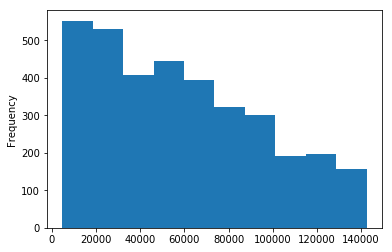

In [8]:
maxval = df['SalaryUSD'].quantile(0.9)
minval = df['SalaryUSD'].quantile(0.1)
print ("Salary will be between ",int(minval),'USD and ',int(maxval),'USD')

df = df[(df['SalaryUSD'] < maxval) &(df['SalaryUSD'] > minval)]
print ('Dataframe size after outlier removal:',df.shape)
df.SalaryUSD.describe()
# plot the historgram of frequences
_ = df.SalaryUSD.plot.hist()


### Variables exploration

The dataframe has a lot of variables : 230. We will focus on a subset of these variables : ['Age','GenderSelect','Country','EmploymentStatus','CurrentJobTitleSelect','MajorSelect']

Since the categorical data are not described with the function `df.describe()`, we will plot the data distribution for each of these variable.



* Plot the distribution of each categorical values with `sns.countplot(data=df3,y='GenderSelect')`


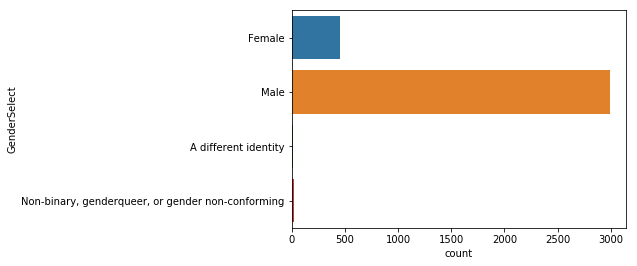

In [9]:
_ = sns.countplot(data=df,y='GenderSelect')


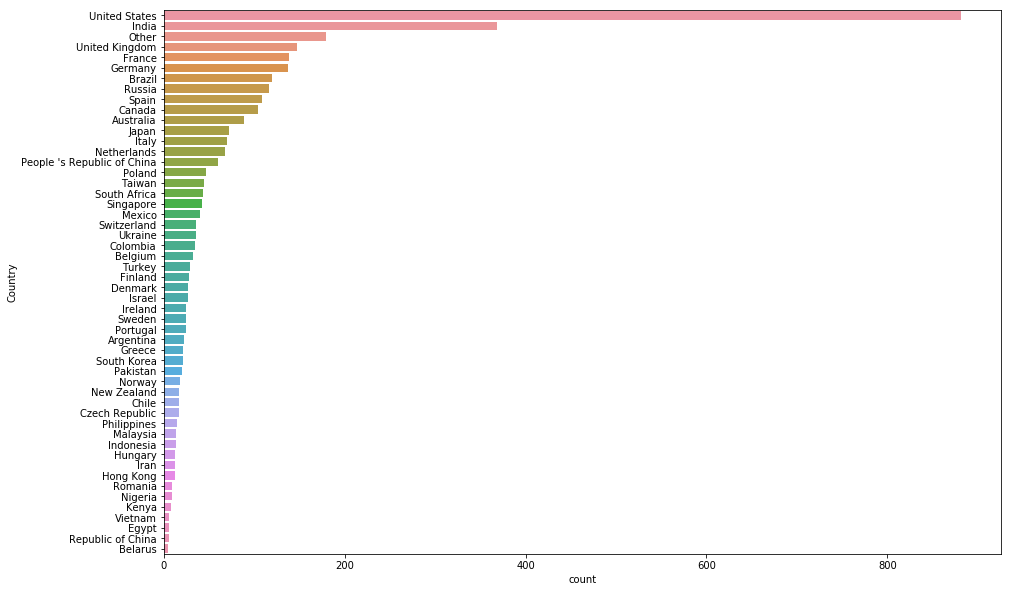

In [10]:
plt.figure(figsize=(15,10))
_ = sns.countplot(data=df,y='Country',order = df['Country'].value_counts().index)

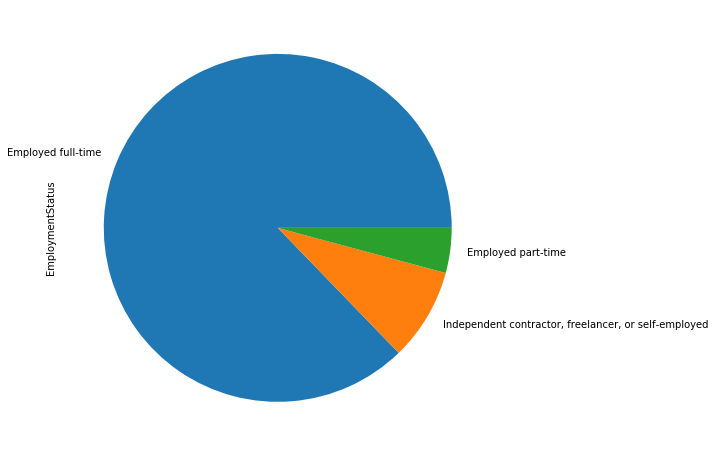

In [11]:
_ = df.EmploymentStatus.value_counts().plot.pie(figsize=(8, 8))

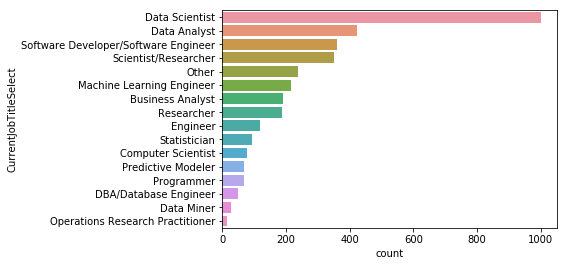

In [12]:
_ = sns.countplot(data=df,y='CurrentJobTitleSelect',order = df['CurrentJobTitleSelect'].value_counts().index)

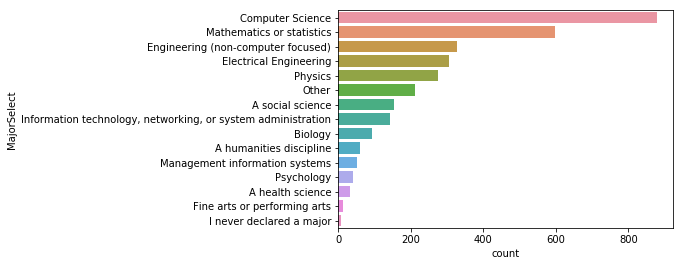

In [13]:
_  = sns.countplot(data=df,y='MajorSelect',order = df['MajorSelect'].value_counts().index)

### Missing data imputation

Some of the values for the selected variables may be missing. We could ignore all the example with missing variable but it would reduce the size of the dataset. The best way to keep the sample with missing values is to fill the missing values. Many technics are possible, but in our case, we wil simply fill the missing values of the age with the mean age.

In [14]:
print ("before filling, number of missing values is",df['Age'].isnull().sum())
df['Age'].fillna(df['Age'].mean(),inplace=True)
print ("after filling, number of missing values is",df['Age'].isnull().sum())
df['Age'].describe()

before filling, number of missing values is 22
after filling, number of missing values is 0


count    3494.000000
mean       33.612039
std         9.029081
min         0.000000
25%        27.000000
50%        32.000000
75%        38.000000
max        99.000000
Name: Age, dtype: float64

Age will be between  21  and  62


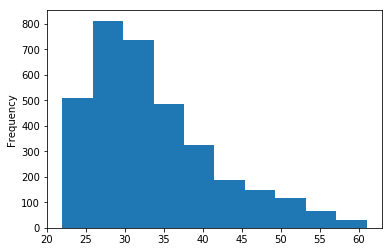

In [15]:
maxval = df['Age'].quantile(0.99)
minval = df['Age'].quantile(0.01)
print ("Age will be between ",int(minval),' and ',int(maxval))

df = df[(df['Age'] < maxval) &(df['Age'] > minval)]
df.shape
_ = df.Age.plot.hist()

The categorical data can not be directly used in most classifiers, their values must be encoded for example with an integer associated to each different category. 
> * Encode the categorical data with a [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html). Missing values must be filled before fitting the encoder (use `fillna('UNK')` on each column).
> * print a few lines of the dataset to see the effect of the encoder.


In [16]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
for c in ['GenderSelect','Country','EmploymentStatus','CurrentJobTitleSelect','MajorSelect']:
    df[c+'_label'] = le.fit_transform(df[c].fillna('UNK'))
    # print the encoded values
    print (c)
    print ([(idx,val) for idx,val in  enumerate(le.classes_)])
    print()
df.head()

GenderSelect
[(0, 'A different identity'), (1, 'Female'), (2, 'Male'), (3, 'Non-binary, genderqueer, or gender non-conforming'), (4, 'UNK')]

Country
[(0, 'Argentina'), (1, 'Australia'), (2, 'Belarus'), (3, 'Belgium'), (4, 'Brazil'), (5, 'Canada'), (6, 'Chile'), (7, 'Colombia'), (8, 'Czech Republic'), (9, 'Denmark'), (10, 'Egypt'), (11, 'Finland'), (12, 'France'), (13, 'Germany'), (14, 'Greece'), (15, 'Hong Kong'), (16, 'Hungary'), (17, 'India'), (18, 'Indonesia'), (19, 'Iran'), (20, 'Ireland'), (21, 'Israel'), (22, 'Italy'), (23, 'Japan'), (24, 'Kenya'), (25, 'Malaysia'), (26, 'Mexico'), (27, 'Netherlands'), (28, 'New Zealand'), (29, 'Nigeria'), (30, 'Norway'), (31, 'Other'), (32, 'Pakistan'), (33, "People 's Republic of China"), (34, 'Philippines'), (35, 'Poland'), (36, 'Portugal'), (37, 'Republic of China'), (38, 'Romania'), (39, 'Russia'), (40, 'Singapore'), (41, 'South Africa'), (42, 'South Korea'), (43, 'Spain'), (44, 'Sweden'), (45, 'Switzerland'), (46, 'Taiwan'), (47, 'Turkey')

,GenderSelect,Country,Age,EmploymentStatus,StudentStatus,LearningDataScience,CodeWriter,CareerSwitcher,CurrentJobTitleSelect,TitleFit,...,JobFactorLeaderReputation,JobFactorDiversity,JobFactorPublishingOpportunity,Salary,SalaryUSD,GenderSelect_label,Country_label,EmploymentStatus_label,CurrentJobTitleSelect_label,MajorSelect_label
8,Female,Australia,43.0,Employed full-time,NaN,NaN,Yes,NaN,Business Analyst,Fine,...,NaN,NaN,NaN,80000.0,64184.8,1,1,0,0,15
9,Male,Russia,33.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,1200000.0,20882.4,2,39,0,14,12
14,Male,Taiwan,26.0,Employed full-time,NaN,NaN,Yes,NaN,Software Developer/Software Engineer,Fine,...,NaN,NaN,NaN,1100000.0,36634.4,2,46,0,14,4
21,Male,United States,25.0,Employed part-time,NaN,NaN,Yes,NaN,Researcher,Fine,...,NaN,NaN,NaN,20000.0,20000.0,2,51,1,12,13
22,Male,United States,33.0,Employed full-time,NaN,NaN,Yes,NaN,Scientist/Researcher,Perfectly,...,NaN,NaN,NaN,100000.0,100000.0,2,51,0,13,5


A decision tree can be used both for classification of for regression. In our case, since we want to predict the salary of a data scientist, we will use decision trees for regression.
> * Define the features X and the target y (= Salary)
> * Fit a decision [DecisionTreeRegressor](http://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html) to predict the Salary


In [17]:
X = df[['Age','GenderSelect_label','Country_label','EmploymentStatus_label','CurrentJobTitleSelect_label','MajorSelect_label']]
#X = df[['Age']]

y = df['SalaryUSD']

In [18]:
from sklearn.tree import DecisionTreeRegressor
regr = DecisionTreeRegressor(max_depth=3)
regr.fit(X, y)


DecisionTreeRegressor(max_depth=3)

The tree can be display to see which rules have been used. The follwing functions plot the decision tree previously trained. 

**Question**:
>  what is the first splitting node ?

In [19]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(regr, out_file=None,feature_names=['Age','GenderSelect_label','Country_label','EmploymentStatus_label','CurrentJobTitleSelect_label','MajorSelect_label'])
graph = graphviz.Source(dot_data)  
graph 

ModuleNotFoundError: No module named 'graphviz'

### Salary prediction

We will now build a model to predict the salary form the selected features. 

**Questions:**
> * split the dataframe in train and test set
> * train a RandomForestRegressor and a ExtraTreesRegressor
> * compare the 2 models with a metric adapted to regression : mean_absolute_error and explained_variance_score

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score


# split the dataframe in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)# YOUR CODE HERE

# train a random forest regressor
forest = RandomForestRegressor(n_estimators=1000)
forest.fit(X_train, y_train)

# evaluate the random forest with regression metrics
y_pred = forest.predict(X_test)
print ('Mean absolute error:',mean_absolute_error(y_test, y_pred))
from sklearn.metrics import explained_variance_score
print ('Explained variance score:',explained_variance_score(y_test, y_pred))


etree = ExtraTreesRegressor(n_estimators=1000)
etree.fit(X_train, y_train)
ey_pred = etree.predict(X_test)
print ('Mean absolute error:',mean_absolute_error(y_test, ey_pred))
print ('Explained variance score:',explained_variance_score(y_test, ey_pred))

Mean absolute error: 20536.835208406013
Explained variance score: 0.44706982947793994
Mean absolute error: 21196.3302351332
Explained variance score: 0.4139440516453087


In [21]:
ts = pd.DataFrame({'pred':ey_pred,'truth':y_test})
ts.head()

,pred,truth
4196,83000.000000,95000.000
4919,111610.500000,125000.000
3103,43685.797492,65606.896
9570,35777.698709,29895.650
10522,35544.372062,35874.780


In [62]:
ts.sort_values(by=['truth'], axis=0,inplace=True)

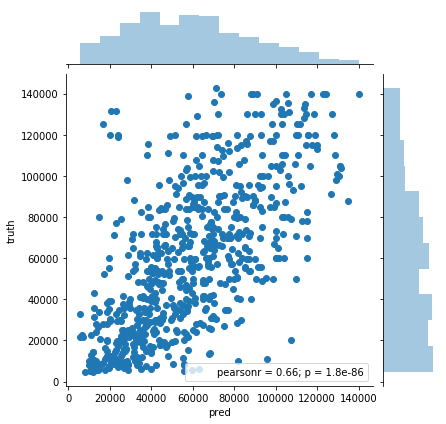

In [63]:
sns.jointplot(data=ts,x='pred',y='truth');

A RandomForest model can also be used to find the most important features in classification or regression problems. The importance of a feature is related to the number of times it is used in the different trees of the random forest.

The following code (adapted form [this code](http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)) plot the feature importance on the Kaggle problem. 

**Question**
> * What is the most important feature to predict the salary ?
> 

In [ ]:

feature_names=['Age','GenderSelect_label','Country_label','EmploymentStatus_label','CurrentJobTitleSelect_label','MajorSelect_label']
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d %s(%f)" % (f + 1, indices[f],feature_names[indices[f]], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

### Predict you salary

You can use the forest to predict you salary (according to Kaggle standards): 

**Question**    
> * create a list with your parameters `['Age','GenderSelect_label','Country_label','EmploymentStatus_label','CurrentJobTitleSelect_label','MajorSelect_label']` encoded with the values previously defined with the LabelEncoder()
> * predict with the forest 

In [ ]:
#['Age','GenderSelect_label','Country_label','EmploymentStatus_label','CurrentJobTitleSelect_label','MajorSelect_label']]
x = np.array([40,0,12,0,12,4]).reshape(1,-1) # reshape to avoid warning
forest.predict(x)